# Thresholding of the E-MFD

In this notebook, we explore how various thresholding and filtering strategies affect the size of the E-MFD. Furthermore, we explore how such thresholding affects how well the words in the E-MFD can discriminate among foundations.

In [11]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

plt.style.use('seaborn-paper')
sns.set_style('whitegrid')
plt.rcParams['font.serif'] = "Times New Roman"

In [12]:
emfd = pd.read_pickle('dictionaries/emfd_scoring.pkl')
probabilities = [c for c in emfd.columns if c.endswith('_p')]

In [13]:
emfd['var'] = emfd[probabilities].var(axis=1)

For Fisher's Z-transformation of correlations, we rely on https://stats.stackexchange.com/questions/109028/fishers-z-transform-in-python#109042

The Fisher transform equals the inverse hyperbolic tangent/arctanh

***

## 1) Effect of Variance and Probability Thresholding on Dictionary Size

In the following, we examine two types of thresholding methods:
- Variance cutoffs: We compute the variance across the foundation probabilities and only keep words that have a minimum probability variance across foundations.
- Probability cutoffs: We filter words that do not have minimum probability to be highlighted with any of the five foundations.

### Variance Cutoffs:

In [14]:
# Create arrays for variance thresholds
var_array = []
for i in np.arange(0.0,1.01, 0.01):
    var_array.append(emfd['var'].quantile(i))
var_array = pd.Series(var_array)

In [15]:
# Create array with dictionary size for variance tresholds
var_dict_size = []
var_corr = []

for i in var_array:
    var_dict_size.append(len(emfd[emfd['var'] >= i]))
    reduced = emfd[emfd['var'] >= i]
    avg_corr = np.arctanh(reduced.corr()[probabilities].loc[probabilities]).replace(np.inf, np.nan).mean()
    var_corr.append(avg_corr)
    
var_dict_size = pd.Series(var_dict_size)
var_corr = pd.concat(var_corr, axis=1).T

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in arctanh
  


### Probability Cutoffs:

In [16]:
# Create array for minimum probability per foundation
p_array = np.arange(0.0,1.1, 0.01)
p_dict_size = []
p_corr = []

for p in p_array:
    reduced = emfd.iloc[pd.np.where(emfd[probabilities].ge(p).any(1, skipna=True))]
    p_dict_size.append(len(reduced))    
    avg_corr = np.arctanh(reduced.corr()[probabilities].loc[probabilities]).replace(np.inf, np.nan).mean()
    p_corr.append(avg_corr)
    
p_dict_size = pd.Series(p_dict_size)
p_corr = pd.concat(p_corr, axis=1).T

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in arctanh
  if __name__ == '__main__':


In [17]:
# Combine and plot 
thresh_plot = pd.DataFrame([var_array.rename('Thresholds'), var_dict_size.rename('Variance Cutoff'), p_dict_size.rename('Probability Cutoff')]).T
var_melted = thresh_plot[['Variance Cutoff']].melt(var_name='Threshold', value_name='Words in E-MFD')
var_melted['Variance Cutoff'] = var_array

p_melted = thresh_plot[['Probability Cutoff']].melt(var_name='Threshold', value_name='Words in E-MFD')
p_melted['Probability Cutoff'] = pd.Series(p_array)

Text(0.5, 1.0, 'Figure 12. Size of E-MFD Across Various Filter Cutoffs')

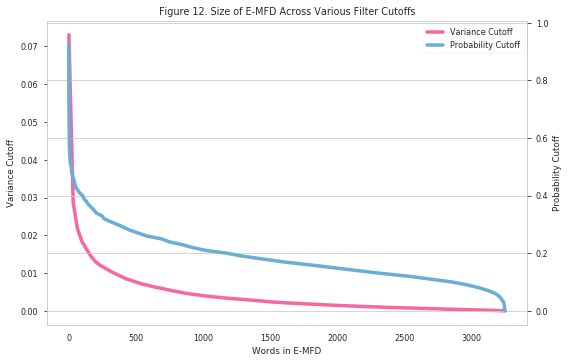

In [18]:
# Combine both and plot 
fig, ax = plt.subplots(figsize=(8,5), sharex=True)
ax = sns.lineplot(x="Words in E-MFD", y="Variance Cutoff", hue='Threshold', data=var_melted, palette='RdPu', linewidth=3.5, label='Variance Cutoff', legend=False)
ax2 = ax.twinx()
sns.lineplot(x="Words in E-MFD", y="Probability Cutoff", hue='Threshold', data=p_melted, ax=ax2, palette='Blues', linewidth=3.5, label='Probability Cutoff', legend=False)
ax.grid(False)
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

ax2.legend(h1+h2, l1+l2, loc=0)
plt.tight_layout()
plt.title('Figure 12. Size of E-MFD Across Various Filter Cutoffs')
# plt.savefig('results/plots/Figure1.pdf', dpi=400)

As the above plot shows, increasing the variance or the probability thresholds results in different dictionary sizes. For example, if each word should have at least a 20% probability to be highlighted by any foundation, the dictionary contains roughly 2,000 words.

***

## 2) Effect of Variance and Probability Thresholding on Correlations between Foundations

Now, we examine how the above filtering methods affect the strenght of association between foundations. For this purpose, we calculated the average correlation of any foundation with all other foundations at every cutoff step. In addition, these correlations were Fisher's Z-transformed (see the above `avg_corr` lines for each type of cutoff).

In [21]:
# Plot Variance Threshold, Dictionary Size, and Corresponding Correlations
var_plot = pd.DataFrame([var_array.rename('Variance Cutoffs'), var_dict_size.rename('Words in E-MFD')]).T
var_plot = var_plot.join(var_corr)
var_plot = var_plot.rename(columns={'care_p':'Care', 'fairness_p':"Fairness", 'loyalty_p':'Loyalty','authority_p':'Authority','sanctity_p':'Sanctity'})

In [22]:
var_found = var_plot[['Care','Fairness','Loyalty','Authority','Sanctity']+['Words in E-MFD']].melt(id_vars='Words in E-MFD', var_name='Foundation',
                                                                                                  value_name='Average Correlation Between Foundations')

Text(0.5, 1.0, 'Figure 13. Assocation between E-MFD Size, Variance Cutoffs, and Mean Correlation Between Foundations')

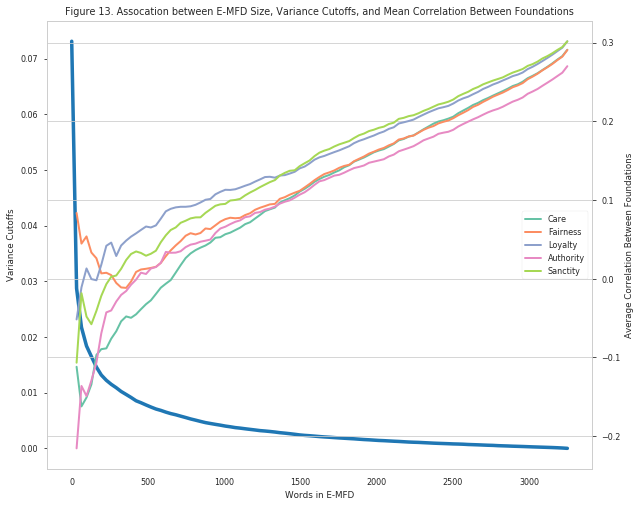

In [24]:
fig, ax = plt.subplots(figsize=(9,7), sharex=True)
ax = sns.lineplot(x="Words in E-MFD", y="Variance Cutoffs", data=var_plot, palette='RdPu', linewidth=3.5, label='Variance Cutoff', legend=False)
ax2 = ax.twinx()
ax.grid(False)
sns.lineplot(x='Words in E-MFD', y="Average Correlation Between Foundations", hue='Foundation', data=var_found, palette='Set2', linewidth=2, label='Care', ax=ax2)
ax2.legend(['Care','Fairness','Loyalty','Authority','Sanctity'], loc=5)
plt.tight_layout()
plt.title('Figure 13. Assocation between E-MFD Size, Variance Cutoffs, and Mean Correlation Between Foundations')
# plt.savefig('results/plots/Figure2.pdf', dpi=400)

In [25]:
# Plot Probability Threshold, Dictionary Size, and Corresponding Correlations
p_plot = pd.DataFrame([pd.Series(p_array).rename('Probability Cutoffs'), p_dict_size.rename('Words in E-MFD')]).T
p_plot = p_plot.join(p_corr)
p_plot = p_plot.rename(columns={'care_p':'Care', 'fairness_p':"Fairness", 'loyalty_p':'Loyalty','authority_p':'Authority','sanctity_p':'Sanctity'})

In [26]:
p_found = p_plot[['Care','Fairness','Loyalty','Authority','Sanctity']+['Words in E-MFD']].melt(id_vars='Words in E-MFD', var_name='Foundation',
                                                                                                  value_name='Average Correlation Between Foundations')

In [27]:
p_found = p_found[p_found['Average Correlation Between Foundations'] < 1]
p_found = p_found[p_found['Words in E-MFD'] > 100]

Text(0.5, 1.0, 'Figure 14. Assocation between E-MFD Size, Probability Cutoffs, and Mean Correlation Between Foundations')

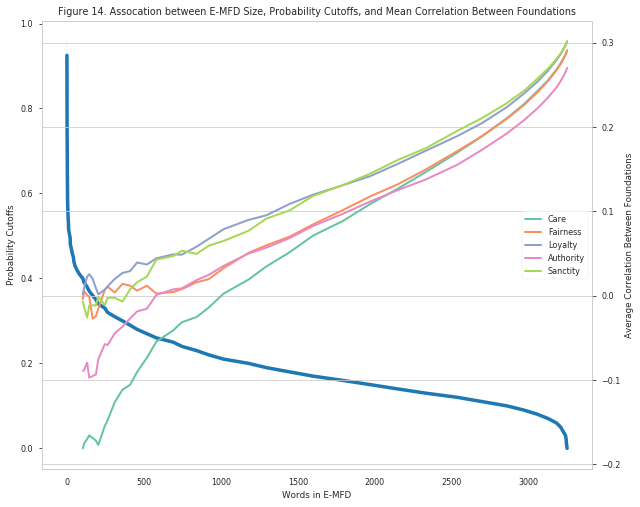

In [29]:
fig, ax = plt.subplots(figsize=(9,7), sharex=True)
ax = sns.lineplot(x="Words in E-MFD", y="Probability Cutoffs", data=p_plot, palette='RdPu', linewidth=3.5, label='Probability Cutoff', legend=False)
ax2 = ax.twinx()
ax.grid(False)
sns.lineplot(x='Words in E-MFD', y="Average Correlation Between Foundations", hue='Foundation', data=p_found, palette='Set2', linewidth=2, label='Care', ax=ax2)
ax2.legend(['Care','Fairness','Loyalty','Authority','Sanctity'], loc=5)
plt.tight_layout()
plt.title('Figure 14. Assocation between E-MFD Size, Probability Cutoffs, and Mean Correlation Between Foundations')
# plt.savefig('results/plots/Figure3.pdf', dpi=400)

An inspection of the two plots suggests that applying a minimum probability per foundation threshold yields better discrimination among foundations than a minumum variance threshold. As the above figure illustrates, a minimum probability threshold of around .3 appears to produce a dicitonary with around 2,000 words in which the foundation scores are minimally correlated across words.  

In [16]:
emfd.corr()[weights_f].loc[weights_f]

,care_norm,fairness_norm,authority_norm,loyalty_norm,sanctity_norm
care_norm,1.000000,0.256219,0.159965,0.203787,0.341629
fairness_norm,0.256219,1.000000,0.254309,0.268732,0.270998
authority_norm,0.159965,0.254309,1.000000,0.347690,0.216401
loyalty_norm,0.203787,0.268732,0.347690,1.000000,0.203243
sanctity_norm,0.341629,0.270998,0.216401,0.203243,1.000000
